<a href="https://colab.research.google.com/github/mintseok/MachineLearning/blob/main/Deep%20Learnig%20from%20Scratch%202/PTB_%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%85%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 구글 드라이브 mount하기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/밑시딥2/deep-learning-from-scratch-2

/content/drive/MyDrive/밑시딥2/deep-learning-from-scratch-2


# 예제를 통해 알아보는 text 분석

In [3]:
text = 'You say goodbye and I say hello.'

In [4]:
import numpy as np

# text 정리
def preprocess(text):
  text = text.lower()
  text = text.replace('.', ' .') # '.'을 ' .'으로 replace
  words = text.split(' ') # 공백을 기준으로 text 분리하기
  # words = ['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

  word_to_id = {}
  id_to_word = {}

  for word in words:
    if word not in word_to_id:
      new_id = len(word_to_id)
      word_to_id[word] = new_id # {'.': 6, 'and': 3, 'goodbye': 2, 'hello': 5, 'i': 4, 'say': 1, 'you': 0}
      id_to_word[new_id] = word # {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

  corpus = np.array([word_to_id[w] for w in words]) # 말뭉치에 대한 index
  
  return corpus, word_to_id, id_to_word

In [5]:
corpus, word_to_id, id_to_word = preprocess(text)
# corpus: array([0, 1, 2, 3, 4, 1, 5, 6])

# 통계 기반 기법 Statistical Based

In [6]:
# 동시 발생 행렬 생성
def create_co_matrix(corpus, vocab_size, window_size=1):
  corpus_size = len(corpus)
  co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32) # n x n 크기의 초기화된 matrix

  for idx, word_id in enumerate(corpus): # idx word_id를 반환해줌
    for i in range(1, window_size + 1): # window_size에 따라 유동적으로 idx를 따져줄 수 있음
      left_idx = idx - i
      right_idx = idx + 1

      if left_idx >= 0:
        left_word_id = corpus[left_idx]
        co_matrix[word_id, left_word_id] += 1

      if right_idx < corpus_size:
        right_word_id = corpus[right_idx]
        co_matrix[word_id, right_word_id] += 1

  return co_matrix

In [7]:
# 벡터간 유사도
def cos_similarity(x, y, eps=1e-8):
  nx = x / np.sqrt(np.sum(x**2)+ eps) # x의 정규화
  ny = y / np.sqrt(np.sum(y**2)+ eps) # y의 정규화
  return np.dot(nx, ny)

In [8]:
vocab_size = len(word_to_id) # 7
C = create_co_matrix(corpus, vocab_size)
# array([[0, 1, 0, 0, 0, 0, 0],
#      [1, 0, 1, 0, 1, 1, 0],
#      [0, 1, 0, 1, 0, 0, 0],
#      [0, 0, 1, 0, 1, 0, 0],
#      [0, 1, 0, 1, 0, 0, 0],
#      [0, 1, 0, 0, 0, 0, 1],
#      [0, 0, 0, 0, 0, 1, 0]], dtype=int32)

c0 = C[word_to_id['you']] # you의 단어 벡터
c1 = C[word_to_id['i']]   # i의 단어 벡터
print(cos_similarity(c0, c1)) # 0.7071067758832467

0.7071067758832467


# 유사도 순위

In [9]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
  # 검색어 꺼내기
  if query not in word_to_id:
    print('%s(을)를 찾을 수 없습니다.' %query)
    return
  
  print('/n[query] '+ query)
  query_id = word_to_id[query]
  query_vec = word_matrix[query_id]

  # 코사인 유사도 계산
  vocab_size = len(id_to_word)
  similarity = np.zeros(vocab_size) # 선언 및 초기화
  for i in range(vocab_size):
    similarity[i] = cos_similarity(word_matrix[i], query_vec) # vector에 대한 유사도 반환
  
  # 코사인 유사도를 기준으로 내림차순으로 출력
  count = 0
  for i in (-1*similarity).argsort(): # np.argsort()는 오름차순으로 정렬 -> -1을 곱해 내림차순
    if id_to_word[i] == query:
      continue
    print(' %s: %s' %(id_to_word[i], similarity[i]))

    count += 1
    if count >= top:
      return

In [10]:
most_similar('you', word_to_id, id_to_word, C, top=5)
# 문제점 -> goodbye와 hello와의 유사도가 i와 비슷한건 우리의 직관과는 멀다
# 개선점 -> PMI, PPMI (pointwise mutual information, positive PMI)

/n[query] you
 goodbye: 0.7071067758832467
 i: 0.7071067758832467
 hello: 0.7071067758832467
 say: 0.0
 and: 0.0


In [11]:
def ppmi(C, verbose=False, eps=1e-8):
  M = np.zeros_like(C, dtype=np.float32) #C와 같은 형태의 array 형성
  N = np.sum(C)
  S = np.sum(C, axis=0)
  total = C.shape[0] * C.shape[1]
  cnt = 0
  
  for i in range(C.shape[0]):
    for j in range(C.shape[1]):
      pmi = np.log2(C[i,j] * N / (S[j]*S[i]) + eps)
      M[i,j] = max(0, pmi)

      if verbose:
        cnt += 1
        if(cnt % (total//100) == 0):
          print('%.1f%% 완료' %(100*cnt/total))
  return M

In [12]:
W = ppmi(C)

np.set_printoptions(precision=3) # 유효 자릿수를 세 자리로 표시
print('동시발생 행렬')
print(C)
print('-'*50)
print('PPMI')
print(W)

동시발생 행렬
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


# 차원 감소

In [13]:
# SVD를 이용한 차원 감소 -> np.linalg.svd(X) 메서드 활용 
#                           ㄴ> linear algebra를 의미

U, S, V = np.linalg.svd(W)
print(W[0]) # [0.    1.807 0.    0.    0.    0.    0.   ]
print(U[0]) # [-1.110e-16  3.409e-01 -4.163e-16 -1.205e-01 -1.110e-16 -9.323e-01 -1.086e-16]
# 희소벡터에서 밀집벡터로!!
# 밀집벡터의 차원감소 -> 2차원으로
print(U[0, :2])

[0.    1.807 0.    0.    0.    0.    0.   ]
[-1.110e-16  3.409e-01 -4.163e-16 -1.205e-01 -1.110e-16 -9.323e-01
 -1.086e-16]
[-1.110e-16  3.409e-01]


In [14]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(id_to_word)
C = create_co_matrix(corpus, vocab_size, window_size=1)
W = ppmi(C)

# SVD
U, S, V = np.linalg.svd(W)

# SVD를 적용한 후 단어간 관계 표시

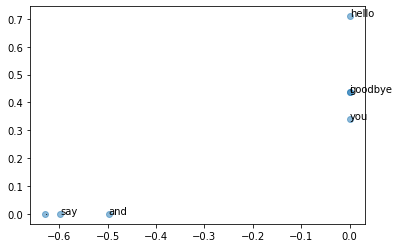

In [15]:
import matplotlib.pyplot as plt

for word, word_id in word_to_id.items():
  plt.annotate(word, (U[word_id, 0], U[word_id, 1]))

plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()

# PTB 데이터셋 다뤄보기

In [29]:
cd /content/drive/MyDrive/밑시딥2/deep-learning-from-scratch-2

/content/drive/MyDrive/밑시딥2/deep-learning-from-scratch-2


In [30]:
import sys
sys.path.append('..')
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')

print('말뭉치 크기: ', len(corpus))
print('corpus[:30]: ', corpus[:30])
print()
print('id_to_word[0]: ', id_to_word[0])
print('id_to_word[1]: ', id_to_word[1])
print('id_to_word[2]: ', id_to_word[2])
print()
print("word_to_id['car']: ", word_to_id['car'])
print("word_to_id['happy']: ", word_to_id['happy'])
print("word_to_id['lexus']: ", word_to_id['lexus'])

말뭉치 크기:  929589
corpus[:30]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]:  aer
id_to_word[1]:  banknote
id_to_word[2]:  berlitz

word_to_id['car']:  3856
word_to_id['happy']:  4428
word_to_id['lexus']:  7426


In [35]:
import numpy as np
from dataset import ptb

window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print("동시발생 수 계산 ...")
C = create_co_matrix(corpus, vocab_size, window_size)
print("PPMI 계산 ...")
W = ppmi(C, verbose=True)

print("SVD 계산 ...")
try:
  #truncated SVD -> 빠르다고 한다
  from sklearn.utils.extmath import randomized_svd
  U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5, random_state=None)

except ImportError:
  # SVD -> 보다 느리다고 한다
  U, S, V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
  most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

동시발생 수 계산 ...
PPMI 계산 ...
1.0% 완료
2.0% 완료
3.0% 완료
4.0% 완료
5.0% 완료
6.0% 완료
7.0% 완료
8.0% 완료
9.0% 완료
10.0% 완료
11.0% 완료
12.0% 완료
13.0% 완료
14.0% 완료
15.0% 완료
16.0% 완료
17.0% 완료
18.0% 완료
19.0% 완료
20.0% 완료
21.0% 완료
22.0% 완료
23.0% 완료
24.0% 완료
25.0% 완료
26.0% 완료
27.0% 완료
28.0% 완료
29.0% 완료
30.0% 완료
31.0% 완료
32.0% 완료
33.0% 완료
34.0% 완료
35.0% 완료
36.0% 완료
37.0% 완료
38.0% 완료
39.0% 완료
40.0% 완료
41.0% 완료
42.0% 완료
43.0% 완료
44.0% 완료
45.0% 완료
46.0% 완료
47.0% 완료
48.0% 완료
49.0% 완료
50.0% 완료
51.0% 완료
52.0% 완료
53.0% 완료
54.0% 완료
55.0% 완료
56.0% 완료
57.0% 완료
58.0% 완료
59.0% 완료
60.0% 완료
61.0% 완료
62.0% 완료
63.0% 완료
64.0% 완료
65.0% 완료
66.0% 완료
67.0% 완료
68.0% 완료
69.0% 완료
70.0% 완료
71.0% 완료
72.0% 완료
73.0% 완료
74.0% 완료
75.0% 완료
76.0% 완료
77.0% 완료
78.0% 완료
79.0% 완료
80.0% 완료
81.0% 완료
82.0% 완료
83.0% 완료
84.0% 완료
85.0% 완료
86.0% 완료
87.0% 완료
88.0% 완료
89.0% 완료
90.0% 완료
91.0% 완료
92.0% 완료
93.0% 완료
94.0% 완료
95.0% 완료
96.0% 완료
97.0% 완료
98.0% 완료
99.0% 완료
100.0% 완료
SVD 계산 ...
/n[query] you
 i: 0.7411095499992371
 we: 0.717390775680542
 'll: 0.553